<a href="https://colab.research.google.com/github/m2pyun/signate_off_road_segmentation/blob/main/off_road_segmentation20210117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
from glob import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
from PIL import Image
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

print(torch.__version__)
print(torch.cuda.is_available())

# 評価対象カテゴリ
eval_names = ('road','dirt road', 'other obstacle')
eval_colors = ((128, 64, 128), (255, 128, 128), (0, 0, 70))

1.7.0+cu101
True


In [3]:
!unzip train_annotations_A_test.zip

Archive:  train_annotations_A_test.zip
   creating: train_annotations_A_test/
  inflating: train_annotations_A_test/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/train_annotations_A_test/
  inflating: __MACOSX/train_annotations_A_test/._.DS_Store  
  inflating: train_annotations_A_test/train_annotation_A0000.png  
  inflating: __MACOSX/train_annotations_A_test/._train_annotation_A0000.png  
  inflating: train_annotations_A_test/train_annotation_A0001.png  
  inflating: __MACOSX/train_annotations_A_test/._train_annotation_A0001.png  
  inflating: train_annotations_A_test/train_annotation_A0002.png  
  inflating: __MACOSX/train_annotations_A_test/._train_annotation_A0002.png  
  inflating: train_annotations_A_test/train_annotation_A0003.png  
  inflating: __MACOSX/train_annotations_A_test/._train_annotation_A0003.png  
  inflating: train_annotations_A_test/train_annotation_A0004.png  
  inflating: __MACOSX/train_annotations_A_test/._train_annotation_A0004.png  
  inflating: tr

In [5]:
!unzip train_images_A_test.zip

Archive:  train_images_A_test.zip
   creating: train_images_A_test/
  inflating: train_images_A_test/.DS_Store  
   creating: __MACOSX/train_images_A_test/
  inflating: __MACOSX/train_images_A_test/._.DS_Store  
  inflating: train_images_A_test/train_image_A0000.png  
  inflating: __MACOSX/train_images_A_test/._train_image_A0000.png  
  inflating: train_images_A_test/train_image_A0001.png  
  inflating: __MACOSX/train_images_A_test/._train_image_A0001.png  
  inflating: train_images_A_test/train_image_A0002.png  
  inflating: __MACOSX/train_images_A_test/._train_image_A0002.png  
  inflating: train_images_A_test/train_image_A0003.png  
  inflating: __MACOSX/train_images_A_test/._train_image_A0003.png  
  inflating: train_images_A_test/train_image_A0004.png  
  inflating: __MACOSX/train_images_A_test/._train_image_A0004.png  
  inflating: train_images_A_test/train_image_A0005.png  
  inflating: __MACOSX/train_images_A_test/._train_image_A0005.png  
  inflating: train_images_A_test/train

In [17]:
train_images_path_list = sorted(glob('off_road/train_images_A/*.png'))
train_annotations_path_list = sorted(glob('off_road/train_annotations_A/*.png'))
precision_test_images_path_list = sorted(glob('off_road/precision_test_images/*.png'))

print('================')
print('学習用画像: ')
print(len(train_images_path_list))
print(train_images_path_list[:5])
print('================')
print('学習用アノテーション: ')
print(len(train_annotations_path_list))
print(train_annotations_path_list[:5])
print('================')
print('精度評価用画像: ')
print(len(precision_test_images_path_list))
print(precision_test_images_path_list[:5])

学習用画像: 
10
['train_images_A_test/train_image_A0000.png', 'train_images_A_test/train_image_A0001.png', 'train_images_A_test/train_image_A0002.png', 'train_images_A_test/train_image_A0003.png', 'train_images_A_test/train_image_A0004.png']
学習用アノテーション: 
10
['train_annotations_A_test/train_annotation_A0000.png', 'train_annotations_A_test/train_annotation_A0001.png', 'train_annotations_A_test/train_annotation_A0002.png', 'train_annotations_A_test/train_annotation_A0003.png', 'train_annotations_A_test/train_annotation_A0004.png']
精度評価用画像: 
10
['precision_test_images_test/precision_test_image_0000.png', 'precision_test_images_test/precision_test_image_0001.png', 'precision_test_images_test/precision_test_image_0002.png', 'precision_test_images_test/precision_test_image_0003.png', 'precision_test_images_test/precision_test_image_0004.png']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


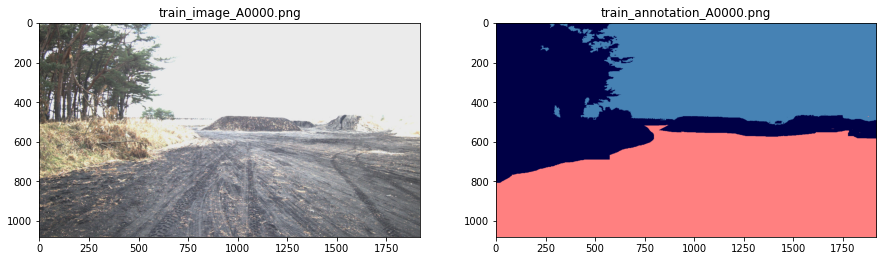

In [14]:
# 画像の読み込み

image_0000 = Image.open('train_images_A_t/train_image_A0000.png')
annotation_0000 = Image.open('train_annotations_A_test/train_annotation_A0000.png')

# 可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes[0].imshow(image_0000)
axes[0].set_title('train_image_A0000.png')

axes[1].imshow(annotation_0000)
axes[1].set_title('train_annotation_A0000.png')

plt.show()

In [16]:
!unzip precision_test_images_test.zip

Archive:  precision_test_images_test.zip
   creating: precision_test_images_test/
  inflating: precision_test_images_test/.DS_Store  
   creating: __MACOSX/precision_test_images_test/
  inflating: __MACOSX/precision_test_images_test/._.DS_Store  
  inflating: precision_test_images_test/precision_test_image_0000.png  
  inflating: __MACOSX/precision_test_images_test/._precision_test_image_0000.png  
  inflating: precision_test_images_test/precision_test_image_0001.png  
  inflating: __MACOSX/precision_test_images_test/._precision_test_image_0001.png  
  inflating: precision_test_images_test/precision_test_image_0002.png  
  inflating: __MACOSX/precision_test_images_test/._precision_test_image_0002.png  
  inflating: precision_test_images_test/precision_test_image_0003.png  
  inflating: __MACOSX/precision_test_images_test/._precision_test_image_0003.png  
  inflating: precision_test_images_test/precision_test_image_0004.png  
  inflating: __MACOSX/precision_test_images_test/._precision_

<BarContainer object of 3 artists>

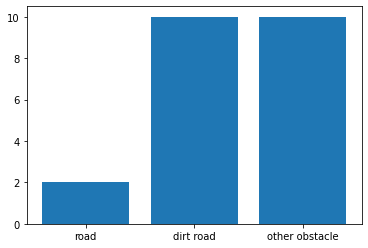

In [18]:
count = {
    'road': 0,
    'dirt road': 0,
    'other obstacle':0
}

for train_annotation_path in train_annotations_path_list:
    image = np.array(Image.open(train_annotation_path))
    
    for eval_name, eval_color in zip(eval_names, eval_colors):
        mask = (image==eval_color).sum(axis=2)==3
        if np.any(mask):
            count[eval_name] += 1
            
plt.bar(count.keys(), count.values())

In [19]:
class OffRoadTransform():
    def __init__(self, image_size, mean, std):
        self.image_size = image_size
        self.mean = mean
        self.std = std
        
    def __call__(self, image, annotation):
        
        # リサイズ
        image = image.resize((self.image_size[1], self.image_size[0]))        
        annotation = annotation.resize((self.image_size[1], self.image_size[0]))
        
        # テンソル化&標準化
        image = transforms.functional.to_tensor(image)
        image = transforms.functional.normalize(image, self.mean, self.std)
        
        # アノテーション画像の色(RGB)情報を以下のように対応するようマッピングし、2次元の配列に変換する
        """
        road(128, 64, 128) -> 1
        dirt road(255, 128, 128) -> 2
        other obstacle(0, 0, 70) -> 3
        上記以外 -> 0
        """
        annotation = np.array(annotation)
        converted_annotation = np.zeros(annotation.shape[:-1])
        for i, eval_color in enumerate(eval_colors):
            mask = (annotation==eval_color).sum(axis=2)==3
            converted_annotation[mask] = i+1
        annotation = torch.from_numpy(converted_annotation)
        
        return image, annotation

In [20]:
class OffRoadDataset(data.Dataset):
    def __init__(self, image_list, annotation_list, transform):
        self.image_list = image_list
        self.annotation_list = annotation_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):

        image_filepath = self.image_list[index]
        annotation_filepath = self.annotation_list[index]
        
        image = Image.open(image_filepath)
        annotation = Image.open(annotation_filepath)

        image, annotation = self.transform(image, annotation)
        
        return image, annotation


In [21]:
train_dataset = OffRoadDataset(train_images_path_list, train_annotations_path_list,
                              transform=OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))

print(train_dataset.__getitem__(0)[0].shape)
print(train_dataset.__getitem__(0)[1].shape)


torch.Size([3, 270, 480])
torch.Size([270, 480])


In [29]:
batch_size = 8
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [22]:
net = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [23]:
net.classifier[-1] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [25]:
def train(net, train_dataloader, criterion, optimizer, n_epoch):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    net.to(device)
    net.train()

    for epoch in range(1, n_epoch+1):
        epoch_train_loss = 0.0
        optimizer.zero_grad()
        
        for images, annotations in train_dataloader:
            images = images.to(device)
            annotations = annotations.to(device)
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = net(images)['out']
                loss = criterion(outputs, annotations.long())
                loss.backward()
                
        print(f'Epoch {epoch} finished')

    pd.to_pickle(net, "tutorial_model.pkl")

In [30]:
train(net, train_dataloader, criterion, optimizer, n_epoch=5)

cuda:0
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished


In [31]:
# 学習済みモデルの読み込み
net = pd.read_pickle("tutorial_model.pkl")

Text(0.5, 1.0, '予測結果')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text

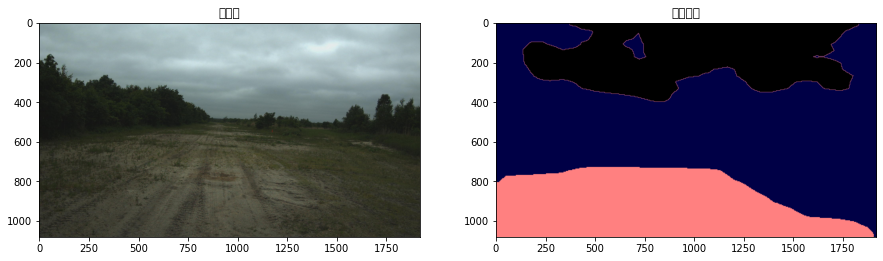

In [32]:
# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()

# 前処理クラスのインスタンス化
test_transform = OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# 画像データの読み込み
test_image_0000 = Image.open('precision_test_images_test/precision_test_image_0000.png')
dummy_annotation = Image.open('train_annotations_A_test/train_annotation_A0000.png')

image_transformed, _ = test_transform(test_image_0000, dummy_annotation)
image_transformed = image_transformed.unsqueeze(0)
image_transformed = image_transformed.to(device)

# 推論の実行
prediction = net(image_transformed)['out']
prediction = prediction[0].to('cpu').detach().numpy()
prediction = np.argmax(prediction, axis=0).astype('uint8')
prediction = np.array(Image.fromarray(prediction).resize([1920, 1080]))

# 推論結果をRGB画像に変換
RGB = np.zeros([1080, 1920, 3], dtype='uint8')
for i, color in enumerate(eval_colors):
    mask = prediction==i+1
    RGB[mask] = color
RGB_prediction = np.array(Image.fromarray(RGB).resize([1920, 1080]))

# 可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes[0].imshow(test_image_0000)
axes[0].set_title('元画像')

axes[1].imshow(RGB_prediction)
axes[1].set_title('予測結果')

In [33]:
def pred2dict(fname, prediction):
    categories = [('road',[128, 64, 128]),('dirt road',[255, 128, 128]),('other obstacle',[0, 0, 70])]
    pred_dict = {}
    pred_dict[fname]={}
    
    for i,category in enumerate(categories):

        category_segments_pred = {}
        x_pred, y_pred = np.where(prediction==(i+1))
        category_pix_pred = {}

        for i,j in zip(x_pred,y_pred):
            if i not in category_pix_pred:
                category_pix_pred[i]=[]
            category_pix_pred[i].append(j)   

        for l in category_pix_pred:
            segments = []
            num_segments = 0
            for i,v in enumerate(sorted(category_pix_pred[l])):
                if i==0:
                    start=v
                    end=v
                else:
                    if v==end+1:
                        end = v
                    else:
                        segments.append([int(start),int(end)])
                        start = v
                        end = v
                        num_segments+=1
            segments.append([int(start),int(end)])
            category_segments_pred[int(l)]=segments
        if len(category_pix_pred):
            pred_dict[fname][category[0]]=category_segments_pred
        
    return pred_dict

In [36]:
def make_submission_file():
    
    categories = [('road',[128, 64, 128]),('dirt road',[255, 128, 128]),('other obstacle',[0, 0, 70])]
    predictions = {}
    
    # デバイスの設定
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    net.eval()
    
    # 前処理クラスのインスタンス化
    test_transform = OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    
    # 画像一枚ずつに対して処理を実行するループ
    for test_image_path in precision_test_images_path_list:
        
        fname = os.path.basename(test_image_path)
        test_image = Image.open(test_image_path)
        dummy_annotation = Image.open('train_annotations_A_test/train_annotation_A0000.png')
        test_image, _ = test_transform(test_image, dummy_annotation)
        
        # ミニバッチ化
        test_image = test_image.unsqueeze(0).to(device)
        
        # 推論の実行
        prediction = net(test_image)['out']
        prediction = prediction[0].to('cpu').detach().numpy()
        prediction = np.argmax(prediction, axis=0).astype('uint8')
        prediction = np.array(Image.fromarray(prediction).resize([1920, 1080]))
        
        # 関数pred2dictを用いて予測画像を辞書形式に変換
        pred_dict = pred2dict(fname, prediction)
        predictions.update(pred_dict)

    with open(f'tutorial_submission.json', 'w') as f:
        json.dump(predictions, f)

In [37]:
make_submission_file()